# California Housing Ridge Regression
Using Hugging Face `gvlassis/california_housing` with a linear regression model (L2 regularization) built in PyTorch.


In [1]:
import torch  # tensors and autograd
from torch import nn  # neural network layers
from torch.utils.data import DataLoader, TensorDataset  # dataset wrappers and loaders
from datasets import load_dataset  # Hugging Face datasets loader
import matplotlib.pyplot as plt  # plotting losses
import numpy as np  # array helpers

torch.manual_seed(42)  # reproducibility
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")


Using device: cpu


In [ ]:
# Load the dataset and identify the target column
# https://huggingface.co/datasets/gvlassis/california_housing
# https://huggingface.co/datasets/scikit-learn/iris
raw_dataset = load_dataset("gvlassis/california_housing")
full_train = raw_dataset["train"]

print(full_train)
print("Columns:", full_train.column_names)

target_candidates = ["MedHouseVal", "median_house_value", "MedianHouseValue", "house_value", "target", "label", "price"]
target_col = None
for cand in target_candidates:
    if cand in full_train.column_names:
        target_col = cand
        break
if target_col is None:
    raise ValueError(f"Could not find target column; available: {full_train.column_names}")

feature_cols = [c for c in full_train.column_names if c != target_col]

# Train/validation split
split = full_train.train_test_split(test_size=0.2, seed=42)
train_split, val_split = split["train"], split["test"]

def to_tensors(ds):
    features = torch.tensor(np.stack([ds[c] for c in feature_cols], axis=1), dtype=torch.float32)
    target = torch.tensor(ds[target_col], dtype=torch.float32).unsqueeze(1)
    return features, target

train_features, train_target = to_tensors(train_split)
val_features, val_target = to_tensors(val_split)

# Standardize using training statistics
feat_mean = train_features.mean(dim=0, keepdim=True)
feat_std = train_features.std(dim=0, keepdim=True).clamp(min=1e-6)
train_features = (train_features - feat_mean) / feat_std
val_features = (val_features - feat_mean) / feat_std

train_ds = TensorDataset(train_features, train_target)
val_ds = TensorDataset(val_features, val_target)

batch_size = 256
num_workers = 2
train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

input_dim = train_features.shape[1]
print(f"Features: {input_dim}, Training samples: {len(train_ds)}, Validation samples: {len(val_ds)}")


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/846k [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/105k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/106k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16640 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset({
    features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal'],
    num_rows: 16640
})
Columns: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']
Features: 8, Training samples: 13312, Validation samples: 3328


In [8]:
# show the data by using pandas
import pandas as pd

my_train = raw_dataset["train"]
sample_df = my_train.shuffle().select(range(10)).to_pandas()
print(sample_df)






   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  4.0473      36.0  5.223368   1.030928       831.0  2.855670     33.90   
1  1.7801      45.0  3.663484   1.031026      1820.0  4.343675     34.02   
2  3.1910      30.0  4.034091   1.061364      3738.0  4.247727     34.00   
3  2.3814      28.0  4.370840   0.987322      2179.0  3.453249     32.67   
4  4.1250      39.0  5.126354   0.981949       645.0  2.328520     37.70   
5  4.5750      45.0  5.578947   1.055556       890.0  2.602339     33.84   
6  3.5865      37.0  5.167539   0.979058       551.0  2.884817     33.94   
7  7.3343      37.0  7.097500   0.975000      1006.0  2.515000     38.58   
8  3.9028      25.0  5.470968   0.987097       436.0  2.812903     39.52   
9  3.2321      20.0  5.375546   1.082969      1117.0  2.438865     34.09   

   Longitude  MedHouseVal  
0    -118.32        2.121  
1    -118.19        1.428  
2    -118.41        2.712  
3    -117.07        1.123  
4    -122.07        2.3

In [3]:
# Simple linear regression model
class RidgeRegression(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.model = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.model(x)

model = RidgeRegression(input_dim).to(DEVICE)
print(model)


RidgeRegression(
  (model): Linear(in_features=8, out_features=1, bias=True)
)


In [4]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    total = 0
    for features, targets in loader:
        features, targets = features.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        preds = model(features)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()

        batch_size = targets.size(0)
        total_loss += loss.item() * batch_size
        total += batch_size

    return total_loss / total

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total = 0
    with torch.no_grad():
        for features, targets in loader:
            features, targets = features.to(DEVICE), targets.to(DEVICE)
            preds = model(features)
            loss = criterion(preds, targets)

            batch_size = targets.size(0)
            total_loss += loss.item() * batch_size
            total += batch_size

    return total_loss / total


In [5]:
epochs = 50
learning_rate = 5e-3
weight_decay = 1e-2  # L2 strength

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

history = {"train_mse": [], "val_mse": []}

for epoch in range(epochs):
    train_mse = train_one_epoch(model, train_loader, criterion, optimizer)
    val_mse = evaluate(model, val_loader, criterion)

    history["train_mse"].append(train_mse)
    history["val_mse"].append(val_mse)

    print(
        f"Epoch {epoch + 1}/{epochs} - Train RMSE: {train_mse**0.5:.4f}, Val RMSE: {val_mse**0.5:.4f}"
    )


Epoch 1/50 - Train RMSE: 1.8461, Val RMSE: 1.6682
Epoch 2/50 - Train RMSE: 1.5751, Val RMSE: 1.4609
Epoch 3/50 - Train RMSE: 1.3691, Val RMSE: 1.3418
Epoch 4/50 - Train RMSE: 1.1996, Val RMSE: 1.1569
Epoch 5/50 - Train RMSE: 1.0636, Val RMSE: 1.0459
Epoch 6/50 - Train RMSE: 0.9585, Val RMSE: 0.9382
Epoch 7/50 - Train RMSE: 0.8796, Val RMSE: 0.8855
Epoch 8/50 - Train RMSE: 0.8252, Val RMSE: 0.8495
Epoch 9/50 - Train RMSE: 0.7897, Val RMSE: 0.8443
Epoch 10/50 - Train RMSE: 0.7668, Val RMSE: 0.8040
Epoch 11/50 - Train RMSE: 0.7541, Val RMSE: 0.8027
Epoch 12/50 - Train RMSE: 0.7466, Val RMSE: 0.7854
Epoch 13/50 - Train RMSE: 0.7422, Val RMSE: 0.7839
Epoch 14/50 - Train RMSE: 0.7403, Val RMSE: 0.8362
Epoch 15/50 - Train RMSE: 0.7379, Val RMSE: 0.7828
Epoch 16/50 - Train RMSE: 0.7374, Val RMSE: 0.7866
Epoch 17/50 - Train RMSE: 0.7370, Val RMSE: 0.8000
Epoch 18/50 - Train RMSE: 0.7370, Val RMSE: 0.7977
Epoch 19/50 - Train RMSE: 0.7365, Val RMSE: 0.8059
Epoch 20/50 - Train RMSE: 0.7372, Val RM

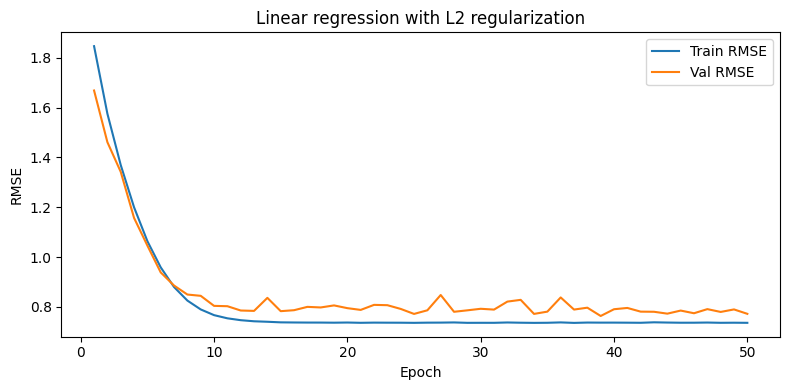

In [6]:
epochs_range = range(1, epochs + 1)
train_rmse = np.sqrt(history["train_mse"])
val_rmse = np.sqrt(history["val_mse"])

plt.figure(figsize=(8, 4))
plt.plot(epochs_range, train_rmse, label="Train RMSE")
plt.plot(epochs_range, val_rmse, label="Val RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Linear regression with L2 regularization")
plt.legend()
plt.tight_layout()
plt.show()
